In [2161]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geoplot.crs as gcrs
import matplotlib as mpl
import matplotlib.colors as colors

pd.set_option('mode.chained_assignment', None)

# Definitions
## Paths and variables

In [2072]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

## Plotting functions

In [2258]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100, reverse=False):
   
    if reverse:
        new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(maxval, minval, n))) 
        
        arr = np.linspace(0, 50, 100).reshape((10, 10))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
        ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
        plt.show()
                
        return new_cmap
   
    else:
        new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
        
        arr = np.linspace(0, 50, 100).reshape((10, 10))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
        ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
        plt.show()
        
        return new_cmap
    
def default_plot(ax, spines): 
    
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax
    
def get_colors(cmap, n):
    cmap = mpl.cm.get_cmap(cmap)
    rgba = [cmap(x) for x in np.linspace(0.01, 0.99, n)]
    sns.palplot(sns.color_palette(rgba));    
    return rgba

def get_single_color(cmap, n):
    cmap = mpl.cm.get_cmap(cmap)
    rgba = cmap(n)
    return rgba

def precinct_selected(precinct, basemap):    
    basemap['selected'] = np.where(basemap.precinct == precinct, 1, 0)   
    ax = geoplot.choropleth(basemap, hue='selected', figsize=(8, 8), lw= 1, edgecolor='k', alpha=1, cmap=new_cmap, projection=gcrs.AlbersEqualArea())
    #geoplot.polyplot(basemap[basemap.precinct == precinct], lw=1, facecolor= get_single_color(new_cmap, .99), edgecolor='k', alpha=1)

def view_clusters(basemap, labeled_data):   
    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], color=cluster_colors[i], alpha=.75, s=75)
        
def temporal_distribution(labeled_data):   
    fig, ax = plt.subplots(figsize=(6,4))
    ax = default_plot(ax, ['left', 'bottom'])
    plt.xlabel('Time of Day')
    plt.ylabel('Density')
    plt.xlim(0, 24)
    
    for i in range(len(labeled_data.labels.unique())):
        sns.kdeplot(labeled_data[labeled_data.labels == i].time, bw=1.5, color=cluster_colors[i], label=str(i), lw=3)    

SyntaxError: invalid syntax (<ipython-input-2258-e5598910fee5>, line 82)

## Algorithm functions

In [2246]:
def make_contour(longitude, latitude, precinct_polygon, colors, levels):
    
    x = longitude
    y = latitude
    
    # check bounds
    xmin = precinct_polygon.bounds['minx'].values
    xmax = precinct_polygon.bounds['maxx'].values
    ymin = precinct_polygon.bounds['miny'].values
    ymax = precinct_polygon.bounds['maxy'].values
    
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    cset = ax.contour(xx, yy, f, colors=colors, levels=levels)
    
    return cset


def get_level(contour, n):
    
    # the n gives you the level
    # just remember that its backwards
    # the outermost level is 0
    
    x = []
    y = []
    for j in range(len(contour.allsegs)):
        for ii, seg in enumerate(contour.allsegs[j]):
            x += [seg[:,0]]
            y += [seg[:,1]]
    
    return list(zip(x[n], y[n]))  

# Choosing colors

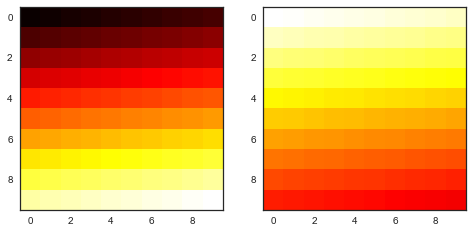

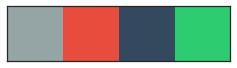

In [2225]:
cmap = plt.get_cmap('hot')
new_cmap = truncate_colormap(cmap, 0.35, 1, reverse=True)

#cluster_colors = get_colors(cmap='cool_r', n=4)
cluster_colors = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(sns.color_palette(cluster_colors));

## Preparing base maps

In [2129]:
# open shapefile
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['pct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

# Read pre-processed data

In [2162]:
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

# transform to datetime
ds['date'] = pd.to_datetime(ds['date'])

## Select crime type

In [2205]:
desc = 'BURGLARY'
ds = crime[crime.description == desc]

# look at number of crime per precinct for exploration
highest_ = ds.groupby('precinct').agg(count=('date', 'count')).sort_values(by='count', ascending=False)
highest_[:10]

,count
precinct,
75,5801
83,5198
105,4925
109,4898
114,4627
67,4432
52,4382
47,4287
104,4210


# Select time and space

In [2247]:
start_date = '2017-09-01'
end_date = '2017-12-31'
precinct = 75
n_clusters = 4

In [2248]:
subselection = ds[(ds.date > start_date) & (ds.date < end_date) & (ds.precinct == precinct)]

# Define and select clustering algorithm

In [2249]:
def make_clusters(data, n):
    
    data = data[['latitude', 'longitude', 'time']]
    stdscaler = StandardScaler()
    features = stdscaler.fit_transform(data)
    cluster = KMeans(n)
    #cluster = AgglomerativeClustering(n)
    model = cluster.fit(features)
    
    # re-label so that cluster 0 is always the largest and so on.
    data['labels'] = model.labels_
    re_labeling = data.labels.value_counts().reset_index()['index']
    data['new_labels'] = data['labels'].replace(list(re_labeling.values), list(re_labeling.index))
    
    return data.new_labels.values

In [2250]:
# run clustering algorithm and get labels
subselection['labels'] = make_clusters(subselection, n_clusters)

# Showing selected area

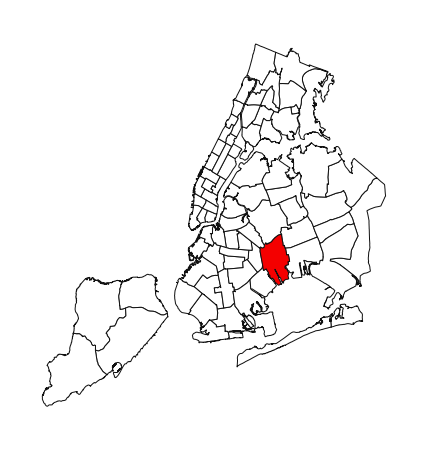

In [2251]:
precinct_selected(precinct, clean_map)

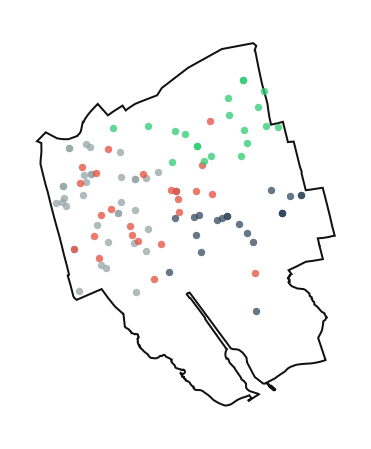

In [2257]:
view_clusters(clean_map, subselection)

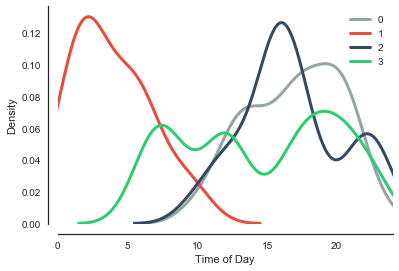

In [2253]:
temporal_distribution(subselection)

In [2018]:

for i in range(len(subselection.labels.unique())):
    

KeyError: 'k_clusters'

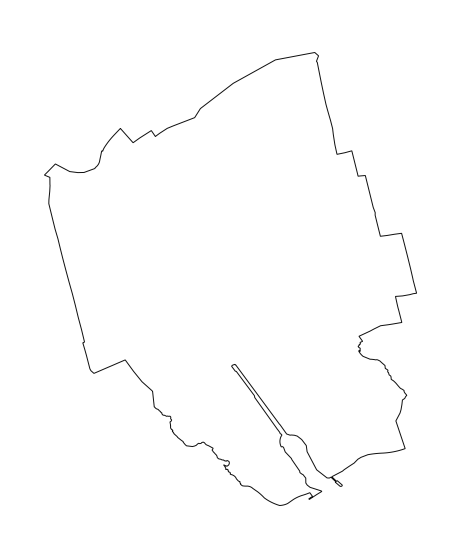

In [2254]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

c0 = make_contour(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='k', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], c='k', alpha=.9)

c1 = make_contour(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='r', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], c='r', alpha=.9)

c2 = make_contour(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='b', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], c='b', alpha=.9)

c3 = make_contour(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='g', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], c='g', alpha=.9)

(0, 24)

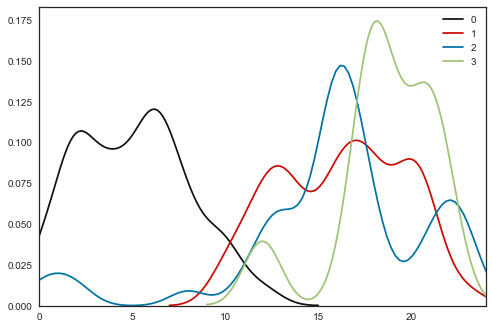

In [2021]:
# show time distributions for these 2 clusters
sns.kdeplot(subselection[subselection.k_clusters == 0].time, bw=1, color='k', label='0')
sns.kdeplot(subselection[subselection.k_clusters == 1].time, bw=1, color='r', label='1')
sns.kdeplot(subselection[subselection.k_clusters == 2].time, bw=1, color='b', label='2')
sns.kdeplot(subselection[subselection.k_clusters == 3].time, bw=1, color='g', label='3')
plt.xlim(0, 24)

In [2022]:
# get ROI
c0_roi = Polygon(get_level(c0, 0))
c1_roi = Polygon(get_level(c1, 0))
c2_roi = Polygon(get_level(c2, 0))
c3_roi = Polygon(get_level(c3, 0))

In [2023]:
# get time window
time0 = subselection[subselection.k_clusters == 0].time.describe()['25%']
time1 = subselection[subselection.k_clusters == 1].time.describe()['25%']
time2 = subselection[subselection.k_clusters == 2].time.describe()['25%']
time3 = subselection[subselection.k_clusters == 3].time.describe()['25%']

time00 = subselection[subselection.k_clusters == 0].time.describe()['75%']
time11 = subselection[subselection.k_clusters == 1].time.describe()['75%']
time22 = subselection[subselection.k_clusters == 2].time.describe()['75%']
time33 = subselection[subselection.k_clusters == 3].time.describe()['75%']

In [2024]:
clusters_k = pd.DataFrame()
clusters_k['geometry'] = [c0_roi, c1_roi, c2_roi, c3_roi]
clusters_k['window_start'] = [time0, time1, time2, time3]
clusters_k['window_end'] = [time00, time11, time22, time33]

In [2025]:
clusters_k

,geometry,window_start,window_end
0,POLYGON ((-73.90404639807407 40.66547800532724...,2.00,7.00
1,POLYGON ((-73.90404639807407 40.67363934520815...,13.00,19.00
2,POLYGON ((-73.85568461223681 40.66926851339413...,13.75,18.00
3,POLYGON ((-73.87962648853384 40.68920447599838...,18.00,20.75


In [2026]:
start_date = '2018-08-01'
end_date = '2018-12-31'

In [2027]:
test_selection = ds[(ds.date > start_date) & (ds.date < end_date) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)

In [2028]:
test_selection

,latitude,longitude,time
0,40.685771,-73.880145,4
1,40.660901,-73.895227,2
2,40.687336,-73.875155,14
3,40.669319,-73.900026,20
4,40.665416,-73.900425,8
...,...,...,...
212,40.660492,-73.870509,15
213,40.665261,-73.868921,21
214,40.678472,-73.902756,11
215,40.664249,-73.879765,13


TypeError: make_contour() missing 1 required positional argument: 'levels'

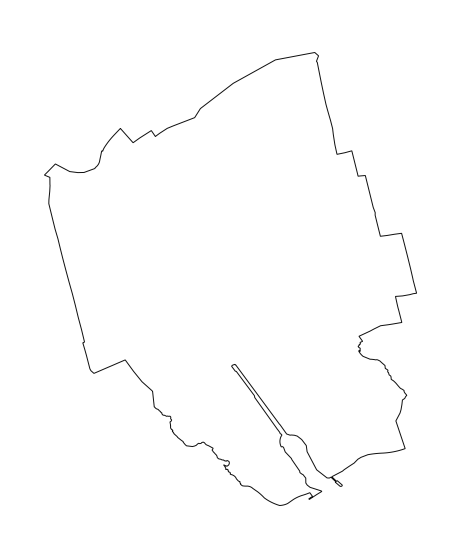

In [2029]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

c0 = make_contour(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='k')

c1 = make_contour(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='r')


c2 = make_contour(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='b')


c3 = make_contour(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='g')


ax.scatter(test_selection['longitude'], test_selection['latitude'], c='orange', alpha=.9, s=100)

In [2030]:
points = [Point(x, y) for x, y in list(zip(test_selection.longitude, test_selection.latitude))]
times = list(test_selection.time.values)

In [2031]:
j = 3
yes = 0
for j in range(len(clusters_k)):
    for i in range(len(points)):
        if (points[i].within(clusters_k.iloc[j]['geometry'])) and (clusters_k.iloc[j]['window_start'] < times[i] < clusters_k.iloc[j]['window_end']):
            yes +=1

In [2032]:
yes

63